# MALA sampling of MLP weights using XOR data

Learn the XOR function by sampling the weights of an MLP via MALA and store chain in file.

In [1]:
## Import packages

import os

import numpy as np

import torch

from torch.utils.data import DataLoader
from torch.distributions import Normal

from eeyore.api import indexify
from eeyore.data import XOR
from eeyore.models import mlp
from eeyore.mcmc import MALA
from eeyore.mcmc import ChainFile

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Load XOR data

xor = indexify(XOR)()
dataloader = DataLoader(xor, batch_size=4)

In [3]:
## Setup MLP model

hparams = mlp.Hyperparameters(dims=[2, 2, 1])
model = mlp.MLP(hparams=hparams)
model.prior = Normal(
    torch.zeros(model.num_params(), dtype=model.dtype),
    np.sqrt(3)*torch.ones(model.num_params(), dtype=model.dtype)
)

In [4]:
## Setup chain

chain = ChainFile(
    keys=['theta', 'target_val', 'grad_val', 'accepted'],
    path=os.path.join(os.getcwd(), 'output')
)

In [5]:
## Setup MALA sampler

theta0 = model.prior.sample()
sampler = MALA(model, theta0, dataloader, step=1.74, chain=chain)

In [6]:
## Run MALA sampler

sampler.run(num_iterations=11000, num_burnin=1000)

In [7]:
## Convert ChainFile instance to ChainList instance

chainlist, _ = sampler.chain.to_chainlist()

In [8]:
## Compute acceptance rate

chainlist.acceptance_rate()

0.5688999891281128

In [9]:
## Compute Monte Carlo mean

chainlist.mean()

tensor([-0.1108,  0.0638,  0.0163, -0.0270, -0.0773, -0.0766, -0.0077,  0.0070,
         0.0220])

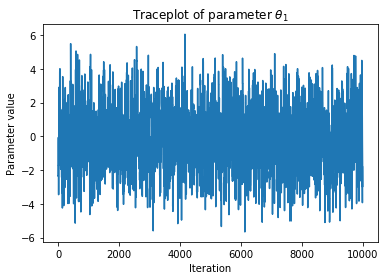

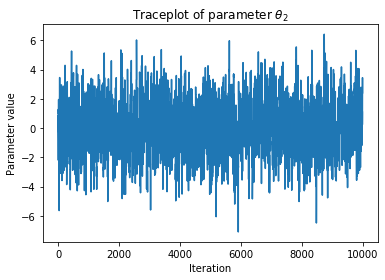

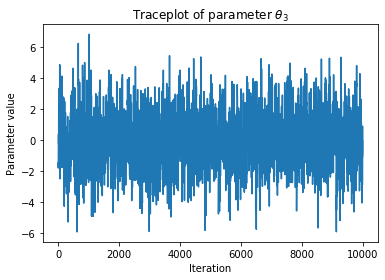

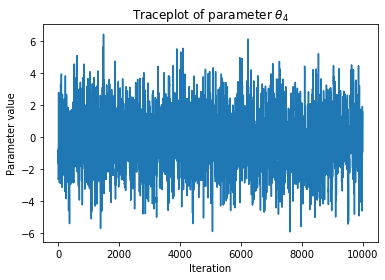

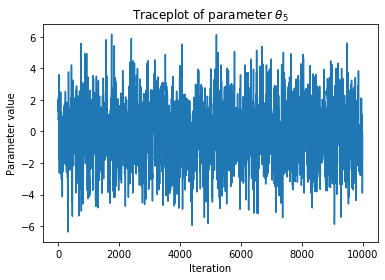

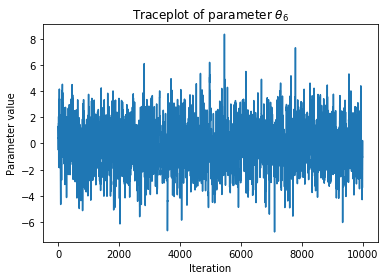

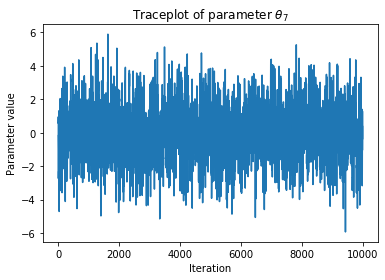

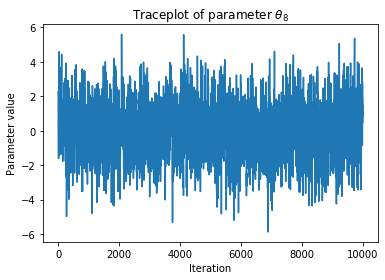

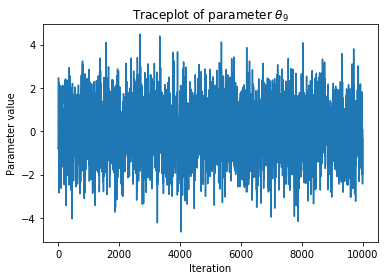

In [10]:
## Plot traces of simulated Markov chain

for i in range(model.num_params()):
    chain = chainlist.get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter $\theta_{}$'.format(i+1))

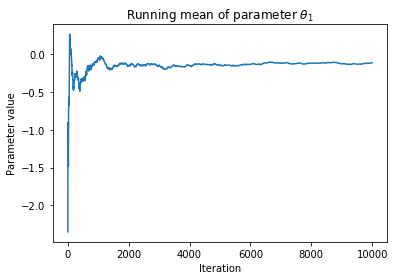

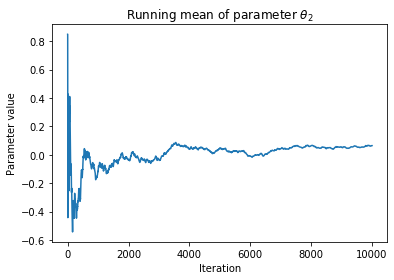

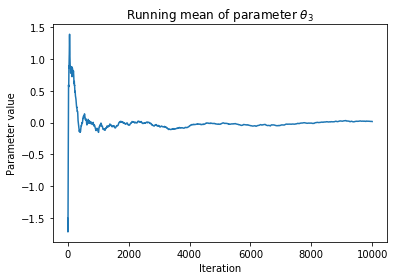

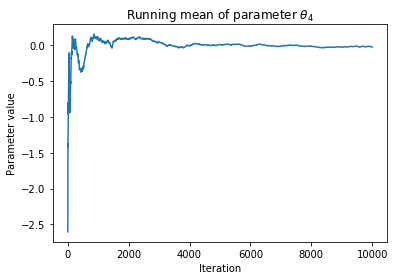

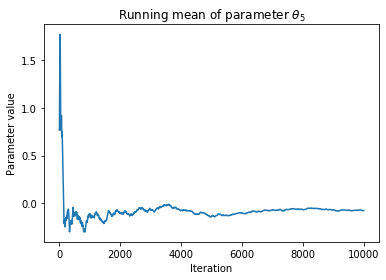

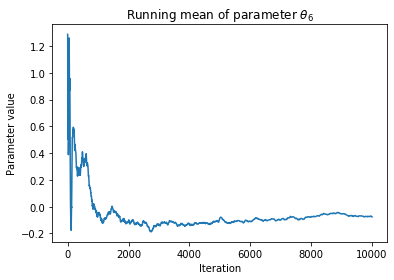

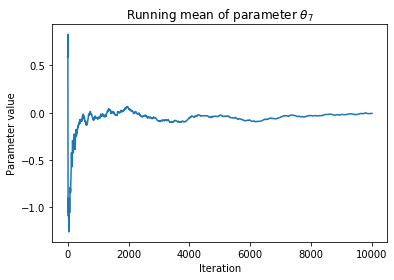

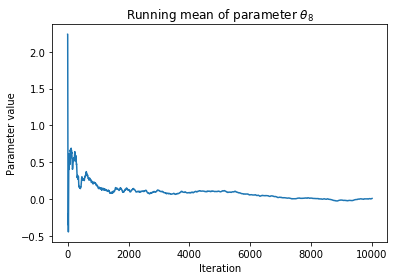

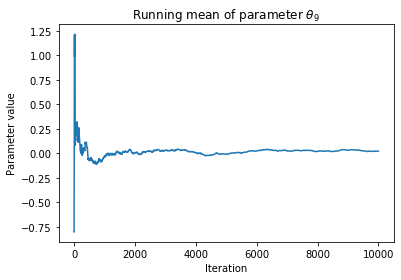

In [11]:
## Plot running means of simulated Markov chain

for i in range(model.num_params()):
    chain = chainlist.get_theta(i)
    chain_mean = torch.empty(len(chain))
    chain_mean[0] = chain[0]
    for j in range(1, len(chain)):
        chain_mean[j] = (chain[j]+j*chain_mean[j-1])/(j+1)
        
    plt.figure()
    sns.lineplot(range(len(chain)), chain_mean)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Running mean of parameter $\theta_{}$'.format(i+1))

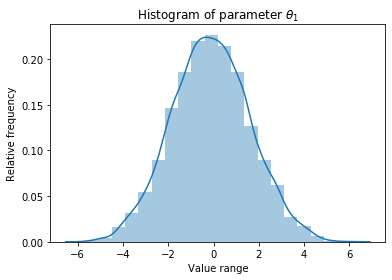

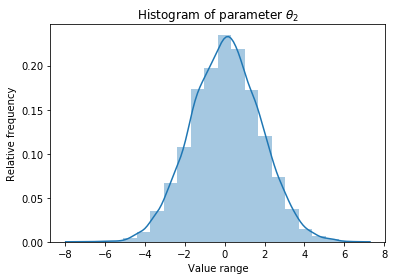

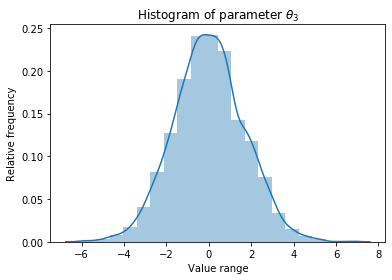

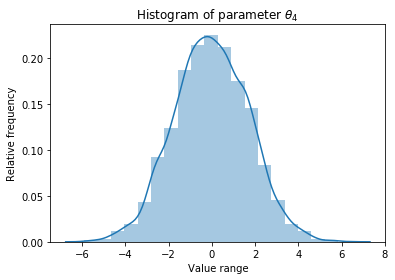

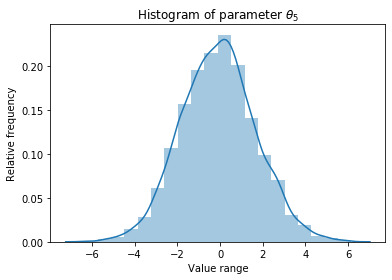

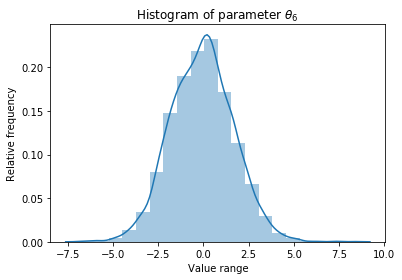

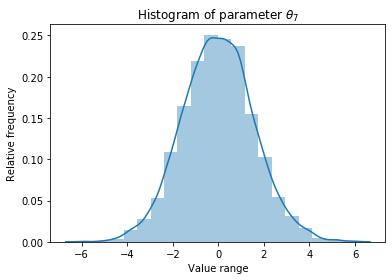

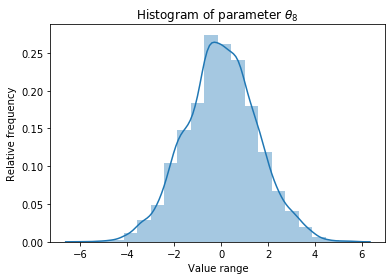

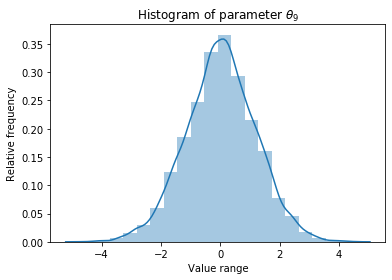

In [12]:
## Plot histograms of simulated Markov chain

for i in range(model.num_params()):
    plt.figure()
    sns.distplot(chainlist.get_theta(i), bins=20, norm_hist=True)
    plt.xlabel('Value range')
    plt.ylabel('Relative frequency')
    plt.title(r'Histogram of parameter $\theta_{}$'.format(i+1))